In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os 
import glob
#import astroalign as aa
from astropy.io import fits
from astropy.stats import sigma_clip
from photutils.aperture import aperture_photometry, CircularAperture
from photutils.centroids import centroid_quadratic
import processing as  pr

/opt/anaconda3/envs/LU3PY232/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. USEFULS FUNCTIONS

In [4]:

def return_flux(image,rad_list,pix_siz = 1,search_center = False,rm_background = True,diagnostic = True):
    """
    A function to measure the flux in apertures
    ...

    Arguments
    ----------
    image : np.array
        the 2D array that contains the photometric image
    rad_list : list
        the list of radius apertures
    pix_siz : float 
        the conversion factor from the unit of rad_list to pixels
        default = 1 (i.e no conversion)
    search_center : boolean
        if True, the centroid is determined in a box of size 300pix around the image center
        default = True
        USE WITH CARE
    rm_background : if True, the background is measured from the median of pixels, and subtracted
        default = True
    diagnostic : if True, a plot with the apertures on top of the images is shown.
    Output
    -------
    phot_table : the list of fluxes in apertures corresponding to rad_list
    bckg : the background ( = 0 if rm_background was set to True)
    
    """
    rad_list = np.array(rad_list)
    rad_pix_list = rad_list/pix_siz 
    default_center = [np.shape(image)[1]//2,np.shape(image)[0]//2]
    if (search_center == True):
        positions = (centroid_quadratic(image, xpeak=default_center[0], ypeak=default_center[1],search_boxsize = 301))
    else:
        positions = default_center
        
    ## masking of pixels with value above the  value at the center of the galaxy
    mask = np.zeros(image.shape, dtype=bool)
    image_center = image[int(positions[1])-20:int(positions[1])+20,int(positions[0])-20:int(positions[0])+20]
    mean_cent = np.mean(image_center)
    std_cent =  np.std(image_center)
    mask[np.where((image-mean_cent)>5*std_cent)] = True
    
    ## plot diagnostic
    if (diagnostic == True):
        mm = np.mean(np.log10(image_center))
        ss = np.std(np.log10(image_center))
        image_clip = np.zeros(np.shape(image))+image
        image_clip[np.where(mask == True)] = 0
        plt.imshow(np.log10(image_clip),origin = 'lower',vmin = mm-2*ss,vmax = mm+ss/2)
        plt.scatter(positions[0],positions[1],color='black',marker = '+',alpha=0.5)
        axes = plt.gca()
        axes.set_xlim(positions[0]-np.max(rad_pix_list)-100,positions[0]+np.max(rad_pix_list)+100)
        axes.set_ylim(positions[1]-np.max(rad_pix_list)-100,positions[1]+np.max(rad_pix_list)+100)

        for k in range(len(rad_pix_list)):
            circle = plt.Circle((positions[0], positions[1]), rad_pix_list[k], color='black',fill=False)
            axes.add_patch(circle)
    
    if (rm_background==True):
        bckg = np.median(image_clip[mask==False])
    else:
        bckg = 0
        
    
    phot_table = np.zeros(len(rad_pix_list))
    for i,aperture_radius in enumerate(rad_pix_list):
        apertures = CircularAperture(positions, r=aperture_radius)  
        phot_table[i] = aperture_photometry(image-bckg, apertures,mask=mask)['aperture_sum'].value[0]

    plt.show()

    return phot_table, bckg

In [5]:
def return_flux_v2(image, rad_list, pix_siz=1.0,
                   search_center=False,
                   rm_background=True,
                   diagnostic=True,
                   diagnostic_scale='log'):
    """
    Mesure le flux intégré dans des ouvertures circulaires croissantes.

    Parameters
    ----------
    image : np.ndarray
        Image 2D en intensité (ex: électrons).
    rad_list : array-like
        Liste des rayons (en même unité, par exemple kpc).
    pix_siz : float
        Conversion de l'unité de rad_list en pixels (par défaut 1.0).
    search_center : bool
        Si True, cherche le centroïde dans une fenêtre autour du centre.
    rm_background : bool
        Si True, soustrait le fond estimé via la médiane hors source.
    diagnostic : bool
        Si True, affiche les cercles et la zone masquée.
    diagnostic_scale : str
        'log' ou 'linear' : échelle d'affichage des intensités.

    Returns
    -------
    flux_list : np.ndarray
        Flux mesuré dans chaque ouverture.
    background_value : float
        Valeur du fond soustrait (0 si rm_background=False).
    """

    rad_list = np.asarray(rad_list)
    rad_pix_list = rad_list / pix_siz
    ny, nx = image.shape

    # === Détection du centre ===
    default_center = [nx // 2, ny // 2]
    if search_center:
        try:
            positions = centroid_quadratic(image, xpeak=default_center[0],
                                           ypeak=default_center[1],
                                           search_boxsize=301)
        except Exception:
            positions = default_center
            print("[!] Centroid failed, fallback to image center.")
    else:
        positions = default_center

    # === Masquage de pixels brillants (sources) ===
    image_center = image[int(positions[1])-20:int(positions[1])+20,
                         int(positions[0])-20:int(positions[0])+20]
    mean_cent = np.mean(image_center)
    std_cent = np.std(image_center)
    mask = (image - mean_cent) > 5 * std_cent

    # === Clipping pour affichage uniquement ===
    image_display = image.copy()
    image_display[mask] = np.nan

    # === Calcul du fond ===
    bckg = np.median(image[~mask]) if rm_background else 0.0

    # === Photométrie ===
    flux_list = np.zeros(len(rad_pix_list))
    for i, r_pix in enumerate(rad_pix_list):
        aperture = CircularAperture(positions, r=r_pix)
        result = aperture_photometry(image - bckg, aperture, mask=mask)
        flux_list[i] = result['aperture_sum'].value[0]

    # === Affichage diagnostic ===
    if diagnostic:
        plt.figure(figsize=(8, 8))
        if diagnostic_scale == 'log':
            img_to_show = np.log10(np.clip(image_display, 1e-3, np.nanmax(image_display)))
        else:
            img_to_show = np.clip(image_display, np.nanmin(image_display), np.nanpercentile(image_display, 99))

        plt.imshow(img_to_show, origin='lower', cmap='gray')
        plt.scatter(positions[0], positions[1], marker='+', color='red', label='centre')

        ax = plt.gca()
        for r_pix in rad_pix_list:
            circle = plt.Circle((positions[0], positions[1]), r_pix, color='cyan', fill=False, alpha=0.4)
            ax.add_patch(circle)

        ax.set_xlim(positions[0]-np.max(rad_pix_list)-100, positions[0]+np.max(rad_pix_list)+100)
        ax.set_ylim(positions[1]-np.max(rad_pix_list)-100, positions[1]+np.max(rad_pix_list)+100)
        ax.set_title("Diagnostic - Ouvertures circulaires")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return flux_list, bckg


In [6]:
def size_luminosity(rad_list,flux_list):
    """
    A function to measure the galaxy size and total luminosity
    ...

    Arguments
    ----------
    rad_list : list
        the list of radius apertures
    flux_list : list
        the list of flux in the above specified apertures
    Output
    -------
    lum : the total flux of the galaxy
    rad : the effective radius of the galaxy
    rad_tot : the minimum radius that encloses the total flux
    
    """
    w = np.where(flux_list == np.max(flux_list))[0]
    lum = flux_list[w]
    w = np.where(np.abs(flux_list - lum/2) == np.min(np.abs(flux_list-lum/2)))[0]
    rad = rad_list[w]
    w = np.where(np.abs(flux_list - lum) == np.min(np.abs(flux_list-lum)))[0]
    rad_tot = rad_list[w]
    return lum,rad,rad_tot

# 2. MEASUREMENT OF SIZE / LUMINOSITY 

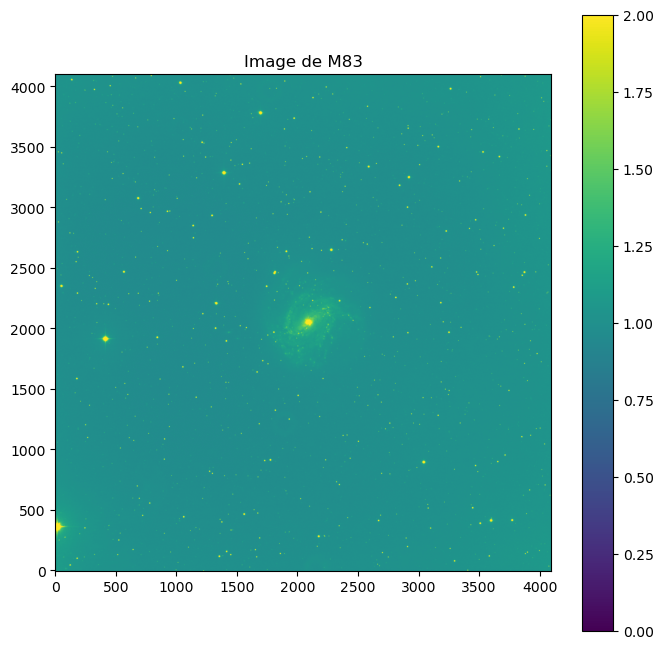

In [147]:
## ouvrir l'image d'une galaxie

# file_name = './Processed/M83_Red_final_calibrated.fits' 
file_name = './images_calibrees/m83_red_calibrated.fits'
image = fits.getdata(file_name)

# plot image
plt.figure(figsize=(8, 8))
plt.imshow(image, origin='lower',vmin = 0,vmax = 2)
plt.colorbar()
plt.title('Image de M83')
plt.show()

**Q1:** Sachant la distance de la galaxie et la taille angulaire d'un pixel (spécifiées dans le [tableur excel](https://dropsu.sorbonne-universite.fr/apps/onlyoffice/s/KRR4sWN4dJsSjmg) ), calculer le facteur de conversion entre pixel et kpc pour cette galaxie.

In [148]:
#pix_size = #kpc/pixel
pix_size = 0.63 
D = 4.66e6 # PC

pix_size_kpc = (pix_size * D / 206265) / 1000 # kpc/pixel
print('pix_size_kpc = ',pix_size_kpc)

pix_size_kpc =  0.014233146680241436


In [149]:
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u

z = 0.0017 # redshift de ta galaxie (ex : 0.0017 pour M83)
scale = cosmo.kpc_proper_per_arcmin(z).to(u.kpc/u.arcsec)  # ex : 0.27 kpc/arcsec

pixel_size_arcsec = 0.63  # ex : 0.63"/pixel
pix_size_kpc = (pixel_size_arcsec * scale).value  # [kpc/pixel]
print('pix_size_kpc = ',pix_size_kpc)

pix_size_kpc =  0.022931421200981385


In [193]:
# Constantes
distance_mpc = 4.66                  # Distance à M83 en Mpc
pixel_scale_arcsec = 0.63           # Taille angulaire d'un pixel
arcsec_to_rad = np.pi / (180.0 * 3600.0)  # Conversion arcsec → radian

# Conversion pixel → kpc
distance_pc = distance_mpc * 1e6    # en parsec
theta_rad = pixel_scale_arcsec * arcsec_to_rad
pixel_size_kpc = (distance_pc * theta_rad) / 1000  # en kpc
print(f"Facteur de conversion : {pixel_size_kpc:.5f} kpc/pixel")

Facteur de conversion : 0.01423 kpc/pixel


**Q2:** Calculer le flux de la galaxie dans differentes ouvertes entre 0.1 et 10kpc
    

/var/folders/br/5q23htp124l05cf1ytsdwlbc0000gp/T/ipykernel_20679/2456354459.py:49: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(image_clip),origin = 'lower',vmin = mm-2*ss,vmax = mm+ss/2)


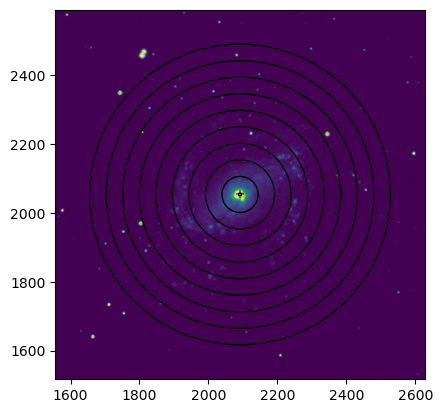

In [194]:
## HELP
rad_list = np.linspace(0.1,10,10)
flux_list, bckg = return_flux(image,rad_list,pix_size_kpc
                              ,search_center = True
                              ,rm_background = True
                              ,diagnostic=True)

# flux_list contient le flux dans une serie d'ouverture entre 0.1 et 10 kpc

**Q3:** Calculer the total luminosity and the effective radius (radius that encloses half the total luminosity)


In [152]:
## HELP:
lum,rad,rad_tot = size_luminosity(rad_list,flux_list)
print('lum = ',lum)
print('rad = ',rad)
print('rad_tot = ',rad_tot)

lum =  [59695.55132555]
rad =  [4.5]
rad_tot =  [10.]


**Q4:** les luminosités apparentes (flux_list et lum) sont en unite electronique. En utilisant le point zero indiqué dans le tableau excel, les convertir en magnitudes apparentes AB

In [219]:
t_exp = 140
flux_per_sec = flux_list / t_exp
lum_per_sec = lum # / t_exp

# Conversion en magnitudes AB
ZP = 19.05
m_AB = -2.5 * np.log10(flux_per_sec) + ZP
mu = 5 * np.log10(distance_pc / 10)

# d'apres mu = m - M
M = m_AB - mu
print('M = ',M)

M =  [-19.52325109 -23.03524738 -23.48713334 -23.70024912 -23.82141032
 -23.89321147 -23.93597267 -23.96366025 -24.01746558 -24.16210489]


**Q5:** Convertir les magnitudes apparentes en magnitudes rest-frame (c'est à dire à 10pc de la source)

In [203]:
mag_rest_frame = M + 5 * np.log10(distance_pc / 10)
print("Magnitudes au cadre de repos:", mag_rest_frame)

Magnitudes au cadre de repos: [17.34249241 14.54943314 13.96496971 13.55237279 13.1726889  12.93505077
 12.76913983 12.61482708 12.52725968 12.47546517]


**Q6:** Tracer l'evolution de la magnitude en fonction du rayon et ajouter une ligne verticale indiquant le rayon effectif

Text(0, 0.5, 'magnitude (AB)')

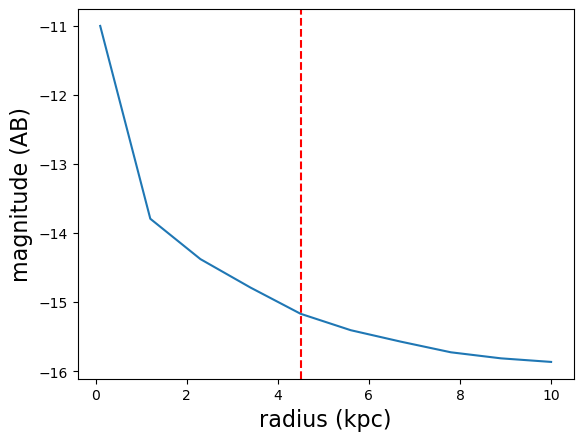

In [204]:
## HELP
plt.plot(rad_list, M)
# vertical line at effective radius
plt.axvline(x=rad, color='r', linestyle='--')
axes = plt.gca()
axes.set_xlabel('radius (kpc)',fontsize=16)
axes.set_ylabel('magnitude (AB)',fontsize=16)

**Q7:** Faire la meme chose pour les autres galaxies dont vous avez les images calibrées
    

# 3. SCALING RELATION SIZE / LUMINOSITY 

In [10]:
magz_ellipt = [-20.194174757281555, -20.32977354179308, -20.32977354179308, -20.65275025599211, -20.725565789972695, -20.85080874544903, -20.85080874544903, -20.444337122648665, -21.069578892976335, -21.225565789972695, -20.996439813410195, -21.132038597921724, -20.68381892824636, -20.809061883722695, -20.7569580078125, -20.631715052336165, -20.861164574484224, -20.81941771275789, -20.96537232630461, -20.840129370828276, -20.96537232630461, -21.07993472201153, -21.2987060546875, -21.46537232630461, -21.18414247383192, -21.31941771275789, -21.45501649726942, -21.39255679232403, -21.27766966588289, -21.621683954035195, -21.78834904050364, -21.78834904050364, -21.569578892976335, -21.694499488015776, -21.64239561210558, -21.486083984375, -21.27766966588289, -21.85080874544903, -21.74660099362864, -21.78834904050364, -21.95501649726942, -21.95501649726942, -21.95501649726942, -22.09061409663228, -22.11132575470267, -22.13203978307039, -21.85080874544903, -21.85080874544903, -21.975728155339805, -22.121683954035195, -22.28834904050364, -22.28834904050364, -22.35080874544903, -22.50712037317961, -22.49676454414442, -22.621683954035195, -22.65307380157767, -22.840452916413835, -22.99676454414442, -23.007442733616504, -22.861489305218445, -22.663429630612864, -22.580258267597088, -22.71553350652306, -22.851133476183254, -22.50712037317961, -22.50712037317961, -22.79902960027306, -22.95533885770631, -23.080258267597088, -22.621683954035195]
reff_ellipt = [1.5036364920323924, 1.1671934913978255, 1.1671934913978255, 1.3255040793180237, 1.4527491799205718, 1.4527491799205718, 1.615067095695038, 1.860047032524925, 1.3635358901542516, 1.3537042309082132, 1.5481376418045563, 1.684890059617907, 1.808165056123628, 1.9268903570358138, 2.17246319457596, 2.3314114839265963, 2.9228700054788113, 3.3899276529316933, 2.5737792133782427, 2.449868184026514, 2.1123301042354807, 1.9134161303581592, 1.8341228941753007, 2.14218652118343, 2.17246319457596, 2.3815363388427038, 2.5201626534829913, 2.723597937648605, 2.6291149233316813, 2.432736913883709, 2.3815363388427038, 2.3815363388427038, 2.685049447067081, 2.9228700054788113, 3.1367243349937426, 3.070704829165085, 3.0279097533131134, 2.821474140561766, 2.685049447067081, 3.1141047508236963, 3.092328652792303, 2.5737792133782427, 2.5737792133782427, 2.841342888155084, 3.1141047508236963, 3.4620512778059527, 3.5364818096244384, 3.5364818096244384, 3.8219575033829973, 3.8219575033829973, 3.6893718303953866, 3.413799435390171, 3.1588130662657576, 3.413799435390171, 3.7686895196430443, 4.159561049587781, 3.8488716288238165, 4.043542366000531, 4.278912016737381, 3.9593047538547586, 4.4638989563946545, 4.495333616869345, 4.790502087631065, 4.927954770660778, 4.824236678870472, 5.325752305029238, 5.325752305029238, 5.325752305029238, 5.796192323790767, 5.715413315729389, 6.176776585219983]


magz_disk = [-20.36310703314624, -20.21197450508192, -20.322977899347695, -20.040452679384103, -20.181552923998787, -20.383495145631066, -20.46407814396238, -20.3025886017142, -20.42394782501517, -20.474110427412015, -20.60550193416262, -20.645631067961165, -20.787054858161408, -20.928155102776092, -21.110032757509103, -21.099676928473908, -20.63559878451153, -20.75663446222694, -20.70614831424454, -20.615534217612257, -20.524595390245754, -20.524595390245754, -20.524595390245754, -20.68608374734527, -20.454045860512743, -20.867637856492717, -20.948543215260923, -21.00906164669296, -21.150161891307647, -21.231068435224515, -21.231068435224515, -21.281553398058254, -21.321682531856794, -21.483172074104974, -21.39255679232403, -21.362136396389563, -21.22103615177488, -21.12006504095874, -21.160194174757283, -21.00906164669296, -20.918122819326456, -20.80711942506068, -20.83754100614381, -21.089643459875607, -21.069578892976335, -21.039158497041868, -20.90809053587682, -20.787054858161408, -20.787054858161408, -20.696116030794904, -20.726537611878033, -20.676051463895632, -20.73656989532767, -21.22103615177488, -21.422653642672937, -21.594174283222088, -21.745631542020632, -21.56407743287318, -21.634628147754853, -21.463106322057037, -21.422653642672937, -21.61423885012136, -21.715211146086165, -21.80614997345267, -21.73559807342233, -21.95728250151699, -22.14919125455097, -22.15922235285194, -22.028154391686893, -21.86666603458738, -21.685113110588592, -21.56407743287318, -21.463106322057037, -21.463106322057037, -21.24110071867415, -21.785760675819176, -21.967638330552184, -22.108737390018202, -22.108737390018202, -22.57281553398058, -22.34077764714806, -22.28025921571602, -22.15922235285194, -22.038187860285195, -21.705177677487864, -21.685113110588592, -22.007767464350728, -22.270225747117717, -22.20970968598301, -22.492232535649272, -22.42168300591626, -22.40129370828277, -22.63333396541262, -22.18964511908374, -22.22977425288228, -22.038187860285195, -21.836245638652912, -22.582849002578882, -22.804853420813107, -22.774757755612864, -21.089643459875607, -20.242071355430824, -20.020064566899272, -23.016829111043688, -20.928155102776092]
reff_disk = [0.7305077602356541, 0.8258860468725422, 1.0417030627346284, 1.0950072414950993, 1.1408388132508438, 1.11516325144177, 1.2325687301272645, 1.289980232146166, 1.38114985899269, 1.5057631132147946, 1.4518236062556378, 1.2325687301272645, 1.38114985899269, 1.485250449087927, 1.4989672952164963, 1.38114985899269, 1.0089406900425395, 1.6268350154033149, 1.8730964839668607, 1.6490620643922178, 1.7899945596527838, 1.7899945596527838, 1.9162232418039469, 2.014570682567339, 2.0796845114930074, 2.117965666275469, 1.898965655779886, 1.7336978365480198, 1.822677419699831, 1.9339202836543326, 1.9339202836543326, 1.710329558814473, 1.5263359864110422, 1.710329558814473, 1.864642815068627, 2.1472161312600977, 2.0796845114930074, 2.2266666559835975, 2.3409471647843425, 2.4722507336621242, 2.3198644974871776, 2.3515602388162273, 2.6109191108787697, 2.5874047193770977, 2.744920465374478, 3.006585275737023, 2.7325320759002114, 2.6109191108787697, 2.6109191108787697, 2.529172605875244, 2.8340540390085125, 3.1037624465301996, 3.3081235870542285, 2.552157441689805, 2.2574189545368384, 2.02370407443461, 1.9964273754111086, 2.236762217913232, 2.3948458626620193, 2.552157441689805, 2.757365388038199, 2.770270467464691, 2.5641024451171974, 2.744920465374478, 2.952242772390612, 2.4722507336621242, 2.4722507336621242, 2.2676533395096774, 2.744920465374478, 3.0476639222715436, 3.292712962660338, 3.061927662997669, 3.3533221186314845, 3.6393734926206087, 3.3685249632036176, 3.5741155029434792, 3.323121960494278, 3.061927662997669, 3.061927662997669, 3.061927662997669, 3.033908784130542, 3.399634103135108, 3.277852273207597, 3.5903193511130898, 3.9142533363542706, 4.287386473619053, 3.8435057068153298, 3.8790008901929722, 4.287386473619053, 3.931999256067118, 4.115146288849563, 4.632116684648166, 5.050045411546503, 5.213270856495423, 5.788253460981814, 6.112916207937106, 6.057862221648741, 6.112916207937106, 6.340028981774115, 7.639762327420236, 3.8261586655104707, 1.9874170888852634, 2.0894178946417523, 4.98197786625372, 5.2852701785342315]

**Q8:** Sur la figure ci-dessous, rajouter vos points de mesure (dans les panneaux correspondants)

In [184]:
magz_ell = np.array(magz_ellipt)
reff_ell = np.array(reff_ellipt)
magz_d = np.array(magz_disk)
reff_d = np.array(reff_disk)

# ---- Linear fit for Elliptical Galaxies ----
coeffs_ell = np.polyfit(magz_ell, reff_ell, 1)
fit_ell = np.polyval(coeffs_ell, magz_ell)
# Estimate the scatter (standard deviation of residuals)
sigma_ell = np.std(reff_ell - fit_ell)

# ---- Linear fit for Disk Galaxies ----
coeffs_disk = np.polyfit(magz_d, reff_d, 1)
fit_disk = np.polyval(coeffs_disk, magz_d)
sigma_disk = np.std(reff_d - fit_disk)

# Generate fit lines for plotting
x_fit_ell = np.linspace(magz_ell.min(), magz_ell.max(), 100)
y_fit_ell = np.polyval(coeffs_ell, x_fit_ell)

x_fit_disk = np.linspace(magz_d.min(), magz_d.max(), 100)
y_fit_disk = np.polyval(coeffs_disk, x_fit_disk)

NameError: name 'magz_ell' is not defined

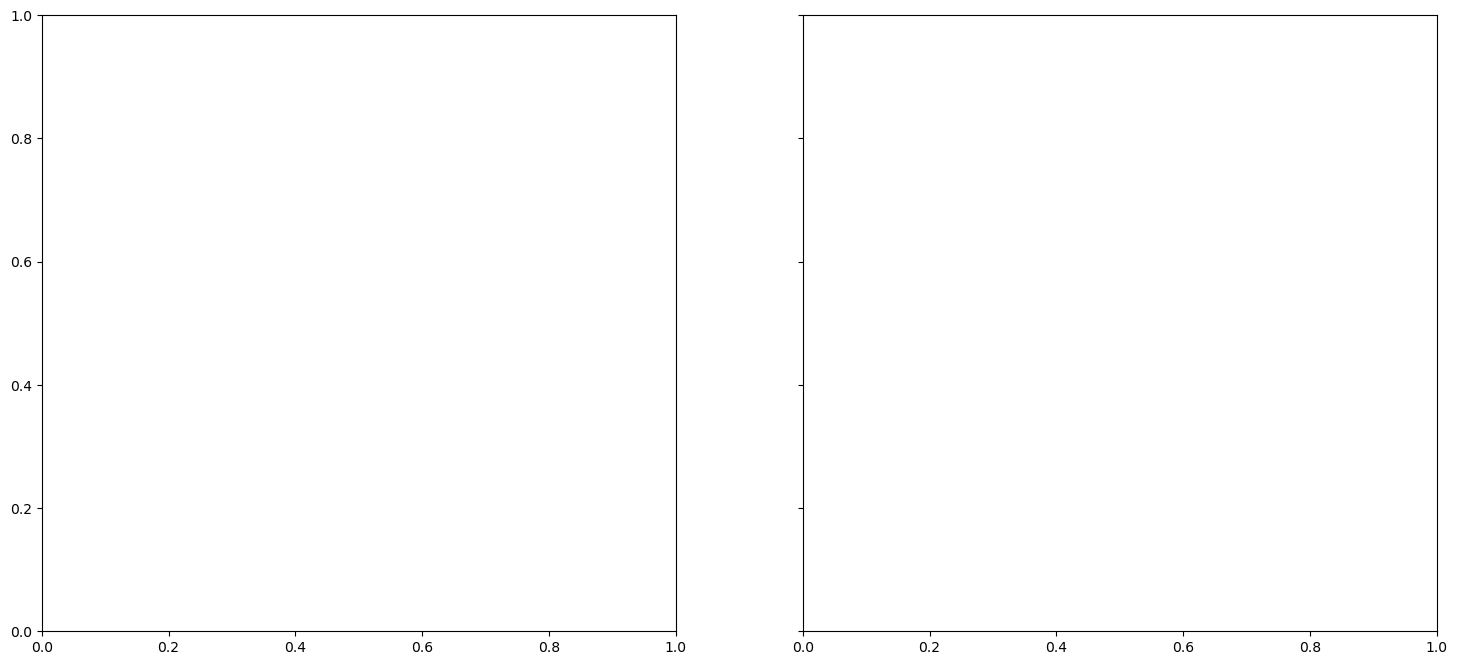

In [11]:
fig, axes = plt.subplots(1,2,figsize = (18,8),sharex=True,sharey=True)

## Panneau de gauche : galaxies elliptiques
ax = axes[0]
ax.errorbar(magz_ell, reff_ell, yerr=sigma_ell, fmt='o', markersize=8,
             color='red', alpha=0.7, label='Ellipticals Data')
# ax.scatter(magz_ellipt,reff_ellipt,s = 200,alpha=0.7,color='red',label = 'galaxies elliptiques, Gadotti+09')
ax.plot(x_fit_ell, y_fit_ell, color='darkred',
         label=f'Ellipticals fit: y = {coeffs_ell[0]:.2f} x + {coeffs_ell[1]:.2f}')

ax.legend(loc = 'lower left', fontsize = 16)
ax.set_xlim(-20,-24)
ax.set_ylim(0.5,20)
ax.set_yscale('log')
ax.set_xlabel('Magnitude (AB)',fontsize=16)
ax.set_ylabel('rayon effectif (kpc)',fontsize=16)
ax.set_title('Galaxies elliptiques',fontsize = 20)
ax.grid()
## Panneau de droite : galaxies disques
ax1 = axes[1]
ax1.errorbar(magz_d, reff_d, yerr=sigma_disk, fmt='o', markersize=8,
            color='blue', alpha=0.7, label='Disks Data')
ax1.plot(x_fit_disk, y_fit_disk, color='darkblue',
         label=f'Disks fit: y = {coeffs_disk[0]:.2f} x + {coeffs_disk[1]:.2f}')
# ax1.scatter(magz_disk,reff_disk,color='blue',s = 200,alpha=0.7,label = 'galaxies disques, Gadotti+09')
# Add a point for the M83 galaxy effective radius (rad) and magnitude (mag_tot)
ax1.scatter(mag_tot,rad, color='green', s=200, alpha=0.7, label='M83 effective radius')
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_xlim(-20.3,-22.7)
ax1.set_ylim(0.5,20)
ax1.set_yscale('log')
ax1.set_xlabel('Magnitude (AB)',fontsize=16)
ax1.set_title('Galaxies disques',fontsize = 20)
ax1.grid()
for i in range(2):
    axes[i].tick_params(axis='both', which='major', labelsize=14)
    axes[i].tick_params(axis='both', which='minor', labelsize=14)

**Q9:** Discuter des sources d'incertitudes, et des effets systematiques

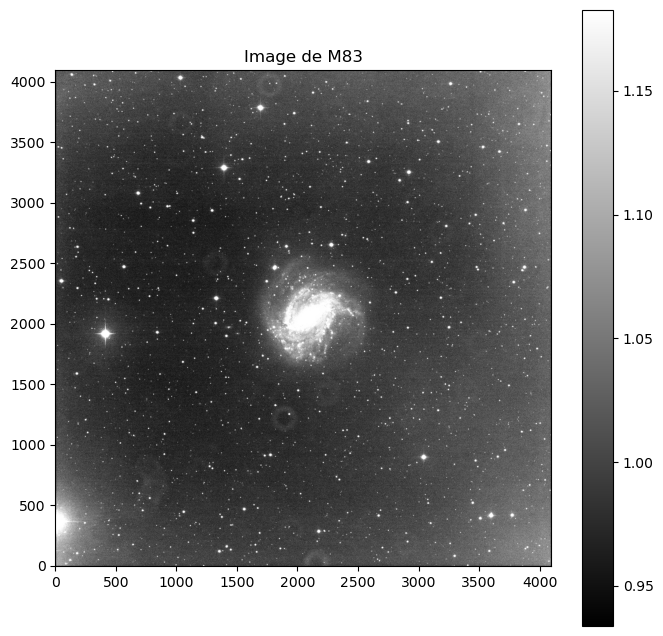

Facteur de conversion : 0.01423 kpc/pixel


/var/folders/br/5q23htp124l05cf1ytsdwlbc0000gp/T/ipykernel_24944/2967106879.py:49: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(image_clip),origin = 'lower',vmin = mm-2*ss,vmax = mm+ss/2)


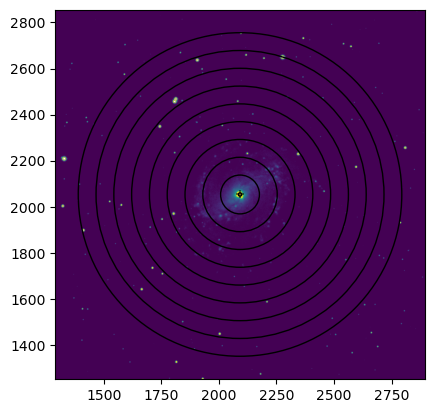

lum =  [63245.61649565]
rad =  [3.4]
rad_tot =  [7.8]
M =  [-17.19006143 -19.57617864 -20.26231377 -20.75104142 -21.03016759
 -21.18697521 -21.25877359 -21.29450566 -21.28964069 -21.22514336]


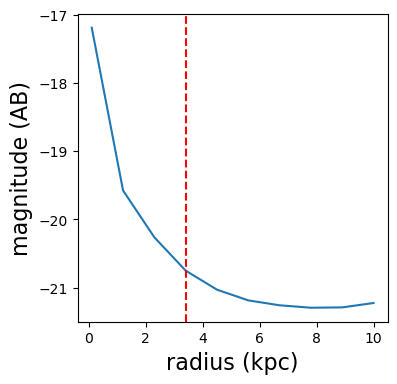

Effective magnitude: -20.75104141674786 Effective radius: [3.4] ref


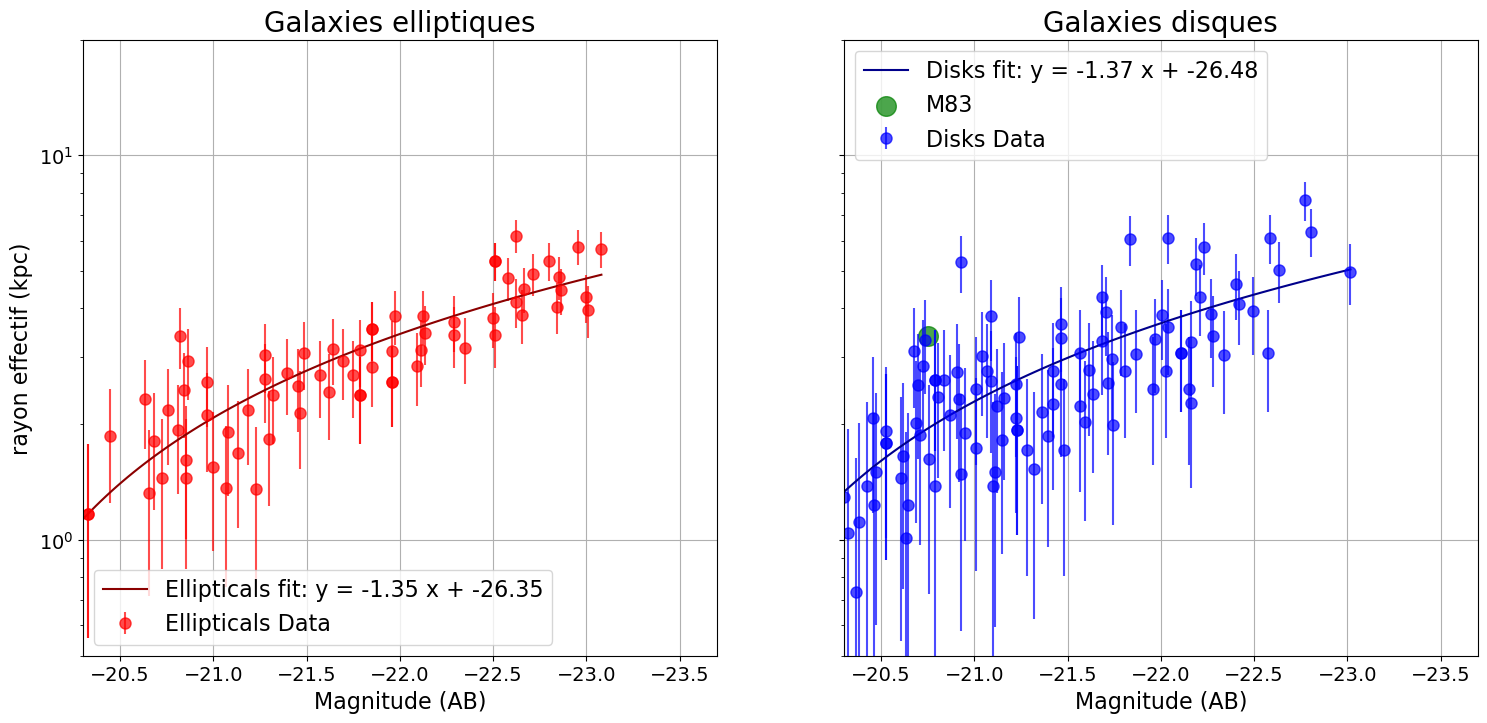

In [15]:
### M83 - Elliptical Galaxy

file_name = './images_calibrees/m83_red_calibrated.fits'
image = fits.getdata(file_name)

hdul = fits.open(file_name)
data = hdul[0].data
# plot image
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray', origin='lower', vmin=np.percentile(data, 5), vmax=np.percentile(data, 99))
plt.colorbar()
plt.title('Image de M83')
plt.show()

# Constantes
distance_mpc = 4.66                  # Distance à M87 en Mpc
pixel_scale_arcsec = 0.63           # Taille angulaire d'un pixel
arcsec_to_rad = np.pi / (180.0 * 3600.0)  # Conversion arcsec → radian
ZP = 19.05

# Conversion pixel → kpc
distance_pc = distance_mpc * 1e6    # en parsec
theta_rad = pixel_scale_arcsec * arcsec_to_rad
pixel_size_kpc = (distance_pc * theta_rad) / 1000  # en kpc
print(f"Facteur de conversion : {pixel_size_kpc:.5f} kpc/pixel")

rad_list = np.linspace(0.1,10,10)
flux_list, bckg = return_flux(image,rad_list,pixel_size_kpc
                              ,search_center = True
                              ,rm_background = True
                              ,diagnostic=True)

lum,rad,rad_tot = size_luminosity(rad_list,flux_list)
print('lum = ',lum)
print('rad = ',rad)
print('rad_tot = ',rad_tot)

# Conversion en magnitudes AB
m_AB = -2.5 * np.log10(flux_list) + ZP
mu = 5 * np.log10(distance_pc / 10)

# d'apres mu = m - M
M = m_AB - mu
print('M = ',M)

plt.figure(figsize=(4, 4))
plt.plot(rad_list, M)
# vertical line at effective radius
plt.axvline(x=rad, color='r', linestyle='--')
axes = plt.gca()
axes.set_xlabel('radius (kpc)',fontsize=16)
axes.set_ylabel('magnitude (AB)',fontsize=16)
plt.show()

idx = np.argmin(np.abs(rad_list - rad))
M_eff = M[idx]
print("Effective magnitude:", M_eff, "Effective radius:", rad, "ref")

fig, axes = plt.subplots(1,2,figsize = (18,8),sharex=True,sharey=True)

magz_ell = np.array(magz_ellipt)
reff_ell = np.array(reff_ellipt)
magz_d = np.array(magz_disk)
reff_d = np.array(reff_disk)

# ---- Linear fit for Elliptical Galaxies ----
coeffs_ell = np.polyfit(magz_ell, reff_ell, 1)
fit_ell = np.polyval(coeffs_ell, magz_ell)
# Estimate the scatter (standard deviation of residuals)
sigma_ell = np.std(reff_ell - fit_ell)

# ---- Linear fit for Disk Galaxies ----
coeffs_disk = np.polyfit(magz_d, reff_d, 1)
fit_disk = np.polyval(coeffs_disk, magz_d)
sigma_disk = np.std(reff_d - fit_disk)

# Generate fit lines for plotting
x_fit_ell = np.linspace(magz_ell.min(), magz_ell.max(), 100)
y_fit_ell = np.polyval(coeffs_ell, x_fit_ell)

x_fit_disk = np.linspace(magz_d.min(), magz_d.max(), 100)
y_fit_disk = np.polyval(coeffs_disk, x_fit_disk)

## Panneau de gauche : galaxies elliptiques
ax = axes[0]
ax.errorbar(magz_ell, reff_ell, yerr=sigma_ell, fmt='o', markersize=8,
             color='red', alpha=0.7, label='Ellipticals Data')
# ax.scatter(magz_ellipt,reff_ellipt,s = 200,alpha=0.7,color='red',label = 'galaxies elliptiques, Gadotti+09')
# ax.scatter(M_eff,rad, color='green', s=200, alpha=0.7, label='M87 effective radius')
ax.plot(x_fit_ell, y_fit_ell, color='darkred',
         label=f'Ellipticals fit: y = {coeffs_ell[0]:.2f} x + {coeffs_ell[1]:.2f}')

ax.legend(loc = 'lower left', fontsize = 16)
ax.set_xlim(-20,-24)
ax.set_ylim(0.5,20)
ax.set_yscale('log')
ax.set_xlabel('Magnitude (AB)',fontsize=16)
ax.set_ylabel('rayon effectif (kpc)',fontsize=16)
ax.set_title('Galaxies elliptiques',fontsize = 20)
ax.grid()
## Panneau de droite : galaxies disques
ax1 = axes[1]
ax1.errorbar(magz_d, reff_d, yerr=sigma_disk, fmt='o', markersize=8,
            color='blue', alpha=0.7, label='Disks Data')
ax1.plot(x_fit_disk, y_fit_disk, color='darkblue',
         label=f'Disks fit: y = {coeffs_disk[0]:.2f} x + {coeffs_disk[1]:.2f}')
# ax1.scatter(magz_disk,reff_disk,color='blue',s = 200,alpha=0.7,label = 'galaxies disques, Gadotti+09')
# Add a point for the M87 galaxy effective radius (rad) and magnitude (mag_tot)
ax1.scatter(M_eff,rad, color='green', s=200, alpha=0.7, label='M83')
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_xlim(-20.3,-23.7)
ax1.set_ylim(0.5,20)
ax1.set_yscale('log')
ax1.set_xlabel('Magnitude (AB)',fontsize=16)
ax1.set_title('Galaxies disques',fontsize = 20)
ax1.grid()
for i in range(2):
    axes[i].tick_params(axis='both', which='major', labelsize=14)
    axes[i].tick_params(axis='both', which='minor', labelsize=14)
plt.show()

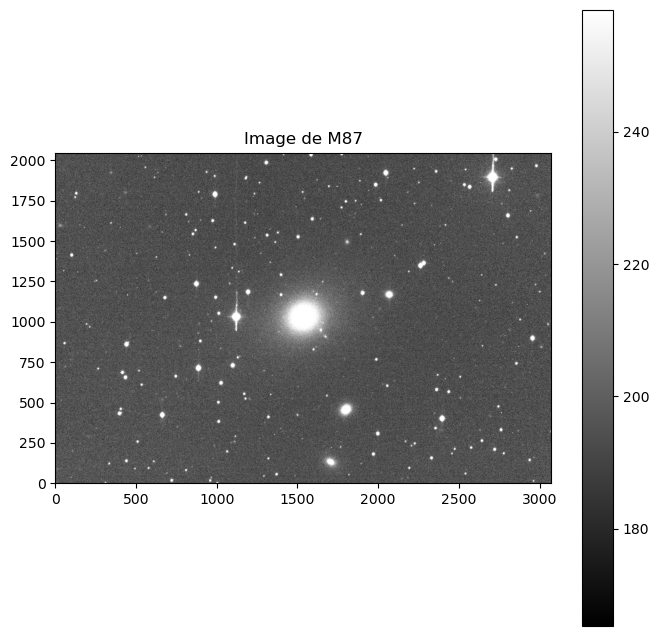

Facteur de conversion : 0.06440 kpc/pixel


/var/folders/br/5q23htp124l05cf1ytsdwlbc0000gp/T/ipykernel_24944/2967106879.py:49: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(image_clip),origin = 'lower',vmin = mm-2*ss,vmax = mm+ss/2)


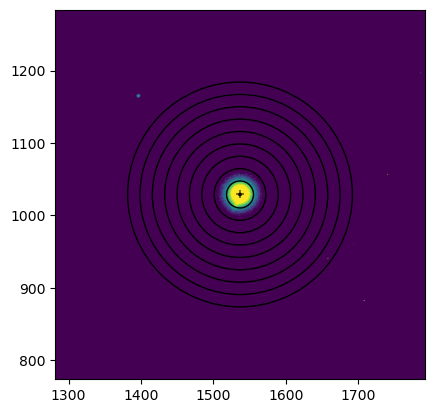

lum =  [6682110.14470803]
rad =  [3.4]
rad_tot =  [10.]
M =  [-16.0475633  -20.68638719 -21.39596859 -21.72741054 -21.93458186
 -22.08250272 -22.19401986 -22.28097477 -22.35176287 -22.40650332]


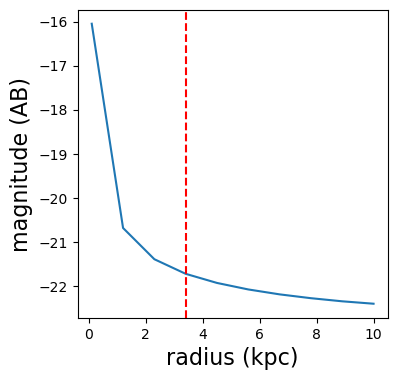

Effective magnitude: -21.727410542730695 Effective radius: [3.4] ref


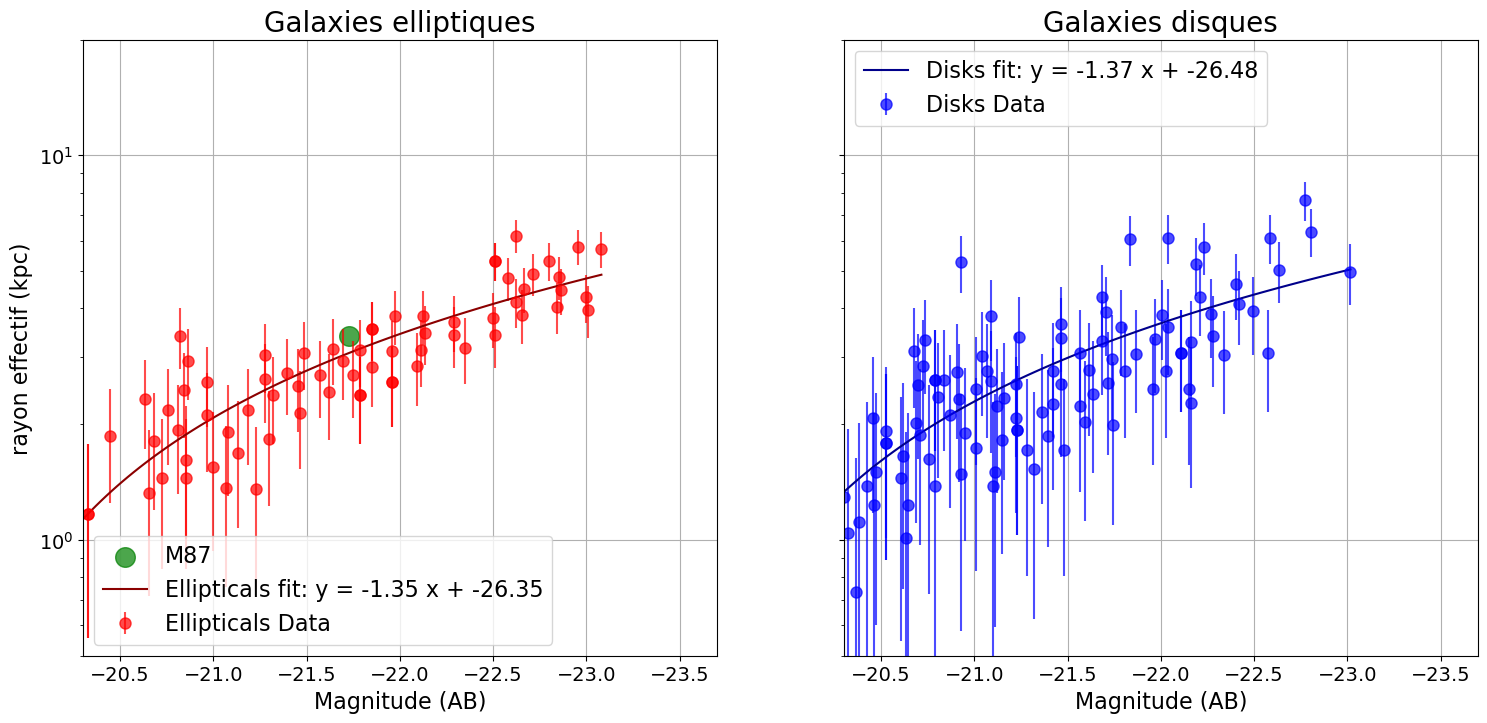

In [ ]:
### M87 - Elliptical Galaxy

file_name = './images_calibrees/m87_green_calibrated_T30.fits'
image = fits.getdata(file_name)

hdul = fits.open(file_name)
data = hdul[0].data
# plot image
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray', origin='lower', vmin=np.percentile(data, 5), vmax=np.percentile(data, 99))
plt.colorbar()
plt.title('Image de M87')
plt.show()

# Constantes
distance_mpc = 16.4                  # Distance à M87 en Mpc
pixel_scale_arcsec = 0.81           # Taille angulaire d'un pixel
arcsec_to_rad = np.pi / (180.0 * 3600.0)  # Conversion arcsec → radian

# Conversion pixel → kpc
distance_pc = distance_mpc * 1e6    # en parsec
theta_rad = pixel_scale_arcsec * arcsec_to_rad
pixel_size_kpc = (distance_pc * theta_rad) / 1000  # en kpc
print(f"Facteur de conversion : {pixel_size_kpc:.5f} kpc/pixel")

rad_list = np.linspace(0.1,10,10)
flux_list, bckg = return_flux(image,rad_list,pixel_size_kpc
                              ,search_center = True
                              ,rm_background = True
                              ,diagnostic=True)

lum,rad,rad_tot = size_luminosity(rad_list,flux_list)
print('lum = ',lum)
print('rad = ',rad)
print('rad_tot = ',rad_tot)

# Conversion en magnitudes AB
ZP = 25.73
m_AB = -2.5 * np.log10(flux_list) + ZP
mu = 5 * np.log10(distance_pc / 10)

# d'apres mu = m - M
M = m_AB - mu
print('M = ',M)

plt.figure(figsize=(4, 4))
plt.plot(rad_list, M)
# vertical line at effective radius
plt.axvline(x=rad, color='r', linestyle='--')
axes = plt.gca()
axes.set_xlabel('radius (kpc)',fontsize=16)
axes.set_ylabel('magnitude (AB)',fontsize=16)
plt.show()

idx = np.argmin(np.abs(rad_list - rad))
M_eff = M[idx]
print("Effective magnitude:", M_eff, "Effective radius:", rad, "ref")

fig, axes = plt.subplots(1,2,figsize = (18,8),sharex=True,sharey=True)

## Panneau de gauche : galaxies elliptiques
ax = axes[0]
ax.errorbar(magz_ell, reff_ell, yerr=sigma_ell, fmt='o', markersize=8,
             color='red', alpha=0.7, label='Ellipticals Data')
# ax.scatter(magz_ellipt,reff_ellipt,s = 200,alpha=0.7,color='red',label = 'galaxies elliptiques, Gadotti+09')

ax.plot(x_fit_ell, y_fit_ell, color='darkred',
         label=f'Ellipticals fit: y = {coeffs_ell[0]:.2f} x + {coeffs_ell[1]:.2f}')
ax.scatter(M_eff,rad, color='green', s=200, alpha=0.7, label='M87')
ax.legend(loc = 'lower left', fontsize = 16)
ax.set_xlim(-20,-24)
ax.set_ylim(0.5,20)
ax.set_yscale('log')
ax.set_xlabel('Magnitude (AB)',fontsize=16)
ax.set_ylabel('rayon effectif (kpc)',fontsize=16)
ax.set_title('Galaxies elliptiques',fontsize = 20)
ax.grid()
## Panneau de droite : galaxies disques
ax1 = axes[1]
ax1.errorbar(magz_d, reff_d, yerr=sigma_disk, fmt='o', markersize=8,
            color='blue', alpha=0.7, label='Disks Data')
ax1.plot(x_fit_disk, y_fit_disk, color='darkblue',
         label=f'Disks fit: y = {coeffs_disk[0]:.2f} x + {coeffs_disk[1]:.2f}')
# ax1.scatter(magz_disk,reff_disk,color='blue',s = 200,alpha=0.7,label = 'galaxies disques, Gadotti+09')
# Add a point for the M87 galaxy effective radius (rad) and magnitude (mag_tot)
# ax1.scatter(M[0],rad, color='green', s=200, alpha=0.7, label='M87 effective radius')
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_xlim(-20.3,-23.7)
ax1.set_ylim(0.5,20)
ax1.set_yscale('log')
ax1.set_xlabel('Magnitude (AB)',fontsize=16)
ax1.set_title('Galaxies disques',fontsize = 20)
ax1.grid()
for i in range(2):
    axes[i].tick_params(axis='both', which='major', labelsize=14)
    axes[i].tick_params(axis='both', which='minor', labelsize=14)
plt.show()